# The MRSAA-c Component
A notebook tutorial of the MRSAA-c landlab component

**Made by Sergio Villamarin**

### Setup

Our MRSAA-c implementation is done on Landlab's Network Model Grid (NMG), you can think of it as a graph. So let's see a quick example of this

<Axes: xlabel='x', ylabel='y'>

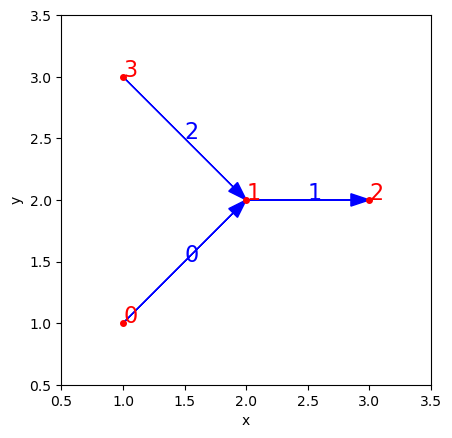

In [1]:
from landlab import NetworkModelGrid
import landlab.plot.graph as graph

x_of_nodes = [1, 1, 2, 3]
y_of_nodes = [3, 1, 2, 2]
links = [(0,2) ,(1,2), (2,3)]

ngrid = NetworkModelGrid((y_of_nodes, x_of_nodes), links)
graph.plot_graph(ngrid, at="node,link", with_id=True)


This allows us to represent river networks and run processes exclusive to them on this grid. In practice we use topographic data which is usually read as a Raster file (equally spaced 2D grid of topographic elevation). For now we will use the following single channel generated raster

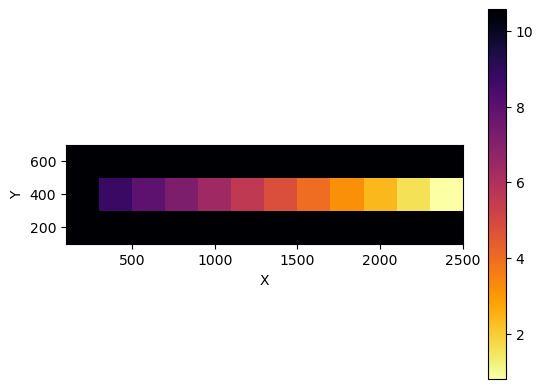

In [42]:
from landlab import imshow_grid
from landlab.io import read_esri_ascii
# store it as a raster file
rastergrid, topography = read_esri_ascii("short_reach.asc")
rastergrid.add_field("topographic__elevation", topography)
# plot spatially the topography
imshow_grid(rastergrid, rastergrid.at_node["topographic__elevation"], cmap='inferno_r')

we can then use landlab's function ```network_grid_from_raster``` to create a NMG (hard to see well but you can see the nodes and the arrows indices on it)

<Axes: xlabel='x', ylabel='y'>

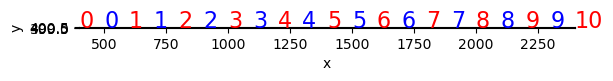

In [82]:
from landlab.grid.create_network import network_grid_from_raster

ngrid = network_grid_from_raster(rastergrid)
graph.plot_graph(ngrid, at="node,link", with_id=True)

Now we need to set up the parameters of the network and sediment. For now we will use default values. Additionally we need the direction of the flow as a ```FlowDirector``` object

In [83]:
from landlab.components import Componentcita as comp
from landlab.components import FlowDirectorSteepest

comp.Componentcita._preset_fields(ngrid=ngrid)
flow_director = FlowDirectorSteepest(ngrid)
flow_director.run_one_step()

And finally create an instance of our component

In [84]:
nety = comp.Componentcita(ngrid, flow_director)

The shape of this specific network is a line so we can plot its field values in a fairly simple way, let's start by plotting the bedrock topography

Text(0.5, 1.0, 'Bedrock')

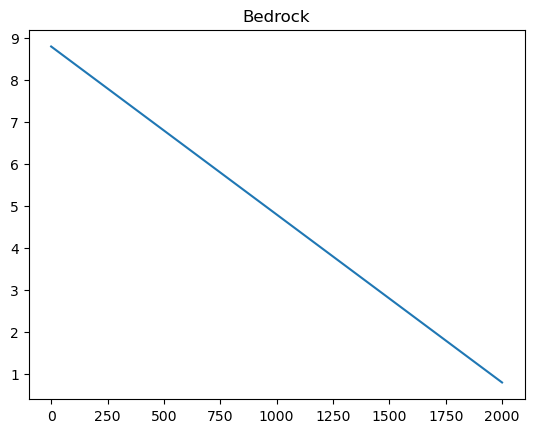

In [85]:
import matplotlib.pyplot as plt
import numpy as np
YEAR = 365.25 * 24 * 60 * 60

# x values are distance downstream (going from left to right)
xs = np.zeros_like(nety._downstream_distance)
xs[1:] = np.cumsum(nety._downstream_distance[:-1])
# y can be any grid landlab fields
ys = ngrid.at_node["bedrock"]
plt.plot(xs, ys)
plt.title("Bedrock")

Now let's see how the alluvium changes as we let the model run for half a year with a constant sediment flux (`q_in=0.000834`) at the upstream end

In [86]:
# setup
dt = YEAR / 1000
one_year = round(1 * YEAR / dt)
total_time = round(0.5 * one_year)
record_time = round(0.1 * one_year)

0.0
0.1
0.2
0.3
0.4
0.5


Text(0.5, 1.0, 'mean alluvium cover')

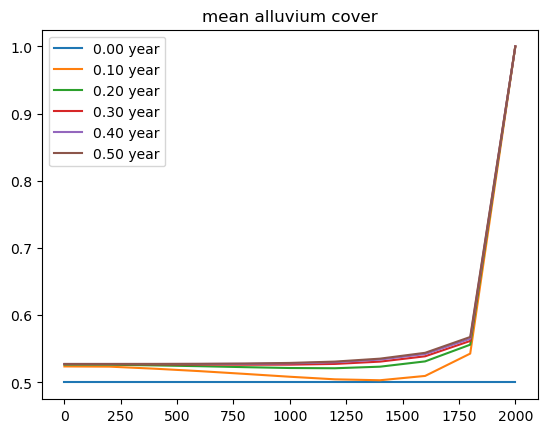

In [87]:
# plot every
for t in range(total_time + 1):
    if t % record_time == 0:
        # plot the new alluvium
        print(t / one_year)
        ys = ngrid.at_node["mean_alluvium_thickness"]
        plt.plot(xs, ys, label=f"{t / one_year :.2f} year")
    nety.run_one_step(dt=dt, q_in=0.000834)
plt.legend()
plt.title("mean alluvium cover")

In [ ]:
print(ngrid["node"].keys())

In [ ]:
# if I want to generate a longer reach, other than that this codeblock can be ignored
# grid parameters
from landlab.io.esri_ascii import write_esri_ascii
from landlab.grid import RasterModelGrid
from landlab import imshow_grid

reach_lenght = 200
total_length = 2000 + reach_lenght
slope = 0.004
steepness = slope * reach_lenght
# grid geometry creation
n = round(total_length / reach_lenght)
shape = (3, n + 1)
cliff_height = steepness * n * 1.2 + 0.01
topography = [cliff_height] * (3 * (n+1))
# create the grid
for i in range(n):
    topography[n + i + 2] = steepness * (n - i)

raster2save = RasterModelGrid(shape, reach_lenght, (200, 200))
raster2save.add_field("topographic__elevation", topography)
imshow_grid(raster2save, raster2save.at_node["topographic__elevation"], cmap='inferno_r')
write_esri_ascii("short_reach.asc", raster2save, clobber=True)